based on pointsim notebook

In [11]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import yaml
import io
from datetime import datetime as dt
from sklearn.metrics import r2_score

sys.path.append("../../src/")
from sarra_py import *

In [12]:
# databse bruelle
observations_full = pd.read_csv("../../data/observations/2006-2010_database_bvlac_bruelle.csv",sep=";")

In [13]:
observations_full = observations_full.groupby(["village","cropseason","sowdate"]).mean().reset_index()

In [14]:
weather_correspondance = {
    "Ambohimiarina":"AgERA5_point_madagascar_Ambohimiarina_-18.83_47.13_2006_2010.csv",
    "Ambohitsilaozana":"AgERA5_point_madagascar_Ambohitsilaozana_-17.7_48.47_2006_2010.csv",
    "Ambongabe":"AgERA5_point_madagascar_Ambongabe_-18.53_48.03_2006_2010.csv",
    "Ampitatsimo":"AgERA5_point_madagascar_Ampitatsimo_-17.81_48.38_2006_2010.csv",
    "Antsahamamy":"AgERA5_point_madagascar_Antsahamamy_-18.92_47.56_2006_2010.csv",

}
rain_correspondance = {
    "Ambohimiarina":"TAMSAT_v3.1_point_madagascar_Ambohimiarina_18.83_47.13_2006_2010.csv",
    "Ambohitsilaozana":"TAMSAT_v3.1_point_madagascar_Ambohitsilaozana_18.92_47.56_2006_2010.csv",
    "Ambongabe":"TAMSAT_v3.1_point_madagascar_Ambongabe_18.53_48.03_2006_2010.csv",
    "Ampitatsimo":"TAMSAT_v3.1_point_madagascar_Ampitatsimo_17.81_48.38_2006_2010.csv",
    "Antsahamamy":"TAMSAT_v3.1_point_madagascar_Antsahamamy_17.7_48.47_2006_2010.csv",
}

In [15]:
def read_and_format_df_weather(file_df_weather, file_df_rain, file_df_irrig, file_df_ET0, date_start, duration):
    # loading weather data and rain data exported from SARRA-H
    # df weather
    # df_weather = pd.read_csv(os.path.join('../../data/weather/',file_df_weather), sep="\t", decimal=",", skiprows=1)
    df_weather = pd.read_csv(os.path.join('../../data/weather/',file_df_weather), sep=",", decimal=".")

    # adaptation AgERA5
    #df_weather["Jour"] = df_weather.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
    df_weather["Jour"] = df_weather.apply(lambda x: datetime.datetime.strptime(x["Jour_SARRA_H"], "%d/%m/%Y").date(), axis=1)
    df_weather = df_weather[(df_weather["Jour"] >= date_start) & (df_weather["Jour"] <= date_start + datetime.timedelta(days=duration-1))].reset_index(drop=True)
    df_weather["TMoy"] = ((df_weather["TMin"] + df_weather["TMax"]) / 2) 

    # df rain
    #df_rain = pd.read_csv(os.path.join('../../data/rain/',file_df_rain), sep="\t", decimal=",", skiprows=1)
    df_rain = pd.read_csv(os.path.join('../../data/rain/',file_df_rain), sep=",", decimal=".")
    # adaptation TAMSAT
    # df_rain["Jour"] = df_rain.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
    df_rain["Jour"] = df_rain.apply(lambda x: datetime.datetime.strptime(x["time"], "%Y-%m-%d").date(), axis=1)

    df_rain = df_rain[(df_rain["Jour"] >= date_start) & (df_rain["Jour"] <= date_start + datetime.timedelta(days=duration-1))].reset_index(drop=True)
    df_rain["RAIN"] = df_rain["rfe_filled"]
    #df_weather = df_weather.merge(df_rain, right_on=["Jour", "CodeStation"], left_on=["Jour", "CodeStation"])
    df_weather = df_weather.merge(df_rain, right_on=["Jour"], left_on=["Jour"])

    df_weather = df_weather.rename(columns={"TMoy":"TEMP", "Pluie":"RAIN", 'Rg':'IRRAD'})

    # df ET0
    if file_df_ET0 == None :
        df_weather["ET0"] = df_weather["ET0_PM"] 

    else:
        df_ET0 = pd.read_csv(os.path.join('../data/et0/',file_df_ET0), sep="\t", decimal=",", skiprows=1)
        df_ET0["Jour"] = df_ET0.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
        df_ET0 = df_ET0[(df_ET0["Jour"] >= date_start) & (df_ET0["Jour"] <= date_start + datetime.timedelta(days=duration-1))].reset_index(drop=True)
        df_weather = df_weather.merge(df_ET0[["Jour","Eto"]], left_on="Jour", right_on="Jour", how="outer")
        df_weather["ET0"] = df_weather["Eto"] # pour code qui appelle Eto/ET0

    # df irrig
    if file_df_irrig == None :
        df_weather["Irrigation"] = 0

    else:
        df_irrig = pd.read_csv(os.path.join('../data/irrig/',file_df_irrig), sep="\t", decimal=",", skiprows=1)
        df_irrig["Jour"] = df_irrig.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
        df_irrig = df_irrig[(df_irrig["Jour"] >= date_start) & (df_irrig["Jour"] <= date_start + datetime.timedelta(days=duration-1))].reset_index(drop=True)
        df_weather = df_weather.merge(df_irrig[["Jour","Irrigation"]], left_on="Jour", right_on="Jour", how="outer")
        df_weather.loc[np.isnan(df_weather["Irrigation"]), "Irrigation"] = 0

    return df_weather



In [16]:
def InitSup2_alt(data, grid_width, grid_height, duration, df_weather_collection):
    data["tpMoy"] = np.concatenate([df_weather_collection[df_weather_id]["TEMP"].values for df_weather_id in df_weather_collection]).reshape(grid_width, grid_height, duration)
    data["rain"] = np.concatenate([df_weather_collection[df_weather_id]["RAIN"].values for df_weather_id in df_weather_collection]).reshape(grid_width, grid_height, duration)
    data["ET0"] = np.concatenate([df_weather_collection[df_weather_id]["ET0"].values for df_weather_id in df_weather_collection]).reshape(grid_width, grid_height, duration)
    data["rg"] = np.concatenate([df_weather_collection[df_weather_id]["IRRAD"].values for df_weather_id in df_weather_collection]).reshape(grid_width, grid_height, duration)
    return data

# Run

# essai optim

In [17]:
import warnings
warnings.filterwarnings("ignore")

# SDJBVP: 400.0 # proposition : 800/2
# SDJRPR: 400.0 # proposition : 800/2
# SDJMatu1: 325.0 # proposition : 650/2
# SDJMatu2: 325.0 # proposition : 650/2

        # paramVariete["SDJBVP"] = SDJBVP
        # paramVariete["SDJRPR"] = SDJRPR
        # paramVariete["SDJMatu1"] = SDJMatu1
        # paramVariete["SDJMatu2"] = SDJMatu2

def run(SDJBVP, SDJRPR, SDJMatu1, SDJMatu2):


    

    df_comparison_total = pd.DataFrame()

    for season in observations_full["cropseason"].unique():
        print("*** season",season,"***")

        observations = observations_full[observations_full["cropseason"]==season].groupby(["village"]).sample(n=10, random_state=123).reset_index(drop=True)
        # observations = observations_full[observations_full["cropseason"]==season].reset_index(drop=True)
        observations["sowdate"] = observations.apply(lambda x: dt.strptime(x["sowdate"],"%Y-%m-%d").date(), axis=1)
        observations["DOY"] = observations.apply(lambda x: x["sowdate"].timetuple().tm_yday, axis=1)

        num_samples = len(observations)
        id_sampling_start = 0

        grid_width = 1
        grid_height = num_samples
        date_start = observations.loc[id_sampling_start:id_sampling_start+num_samples,"sowdate"].values.min()-datetime.timedelta(days=15) # plus petite date en commun entre les dates de semis du set de comparaison
        duration = 365

        # parameter file names
        file_paramVariete = "rice_variety.yaml"
        file_paramITK = "rice_itk.yaml" # date de semis à override
        file_paramTypeSol = "rice_soil.yaml"

        # Read YAML file
        # paramVariete
        with open(os.path.join('../../data/params/variety/',file_paramVariete), 'r') as stream:
            paramVariete = yaml.safe_load(stream)
            
        if paramVariete["feuilAeroBase"] == 0.1 :
            raise exception()

        # paramITK
        with open(os.path.join('../../data/params/itk/',file_paramITK), 'r') as stream:
            paramITK = yaml.safe_load(stream)

        paramITK["DateSemis"] = observations.loc[id_sampling_start:id_sampling_start+num_samples,"sowdate"].values

        # paramTypeSol
        with open(os.path.join('../../data/params/soil/',file_paramTypeSol), 'r') as stream:
            paramTypeSol = yaml.safe_load(stream)

        if ~np.isnan(paramITK["NI"]):
            print("NI NON NULL") 
            paramVariete["txConversion"] = paramVariete["NIYo"] + paramVariete["NIp"] * (1-np.exp(-paramVariete["NIp"] * paramITK["NI"])) - (np.exp(-0.5*((paramITK["NI"] - paramVariete["LGauss"])/paramVariete["AGauss"])* (paramITK["NI"]- paramVariete["LGauss"])/paramVariete["AGauss"]))/(paramVariete["AGauss"]*2.506628274631)

        paramVariete["SDJBVP"] = SDJBVP
        paramVariete["SDJRPR"] = SDJRPR
        paramVariete["SDJMatu1"] = SDJMatu1
        paramVariete["SDJMatu2"] = SDJMatu2

        # building weather dfs
        df_weather_collection = {}
        for sample in tqdm(range(num_samples)):
            location = observations.loc[id_sampling_start+sample,"village"]
            df_weather_collection[sample] = read_and_format_df_weather(weather_correspondance[location], rain_correspondance[location], file_df_irrig=None, file_df_ET0=None, date_start=date_start, duration=duration)


        # looping
        import warnings
        warnings.filterwarnings("ignore")

        data_run = {}

        data_run = InitPlotMc(data_run, grid_width, grid_height, paramITK, paramTypeSol, duration) # **** bileau *** # trad OK
        data_run = InitiationCulture(data_run, grid_width, grid_height, duration, paramVariete)
        data_run = InitSup(data_run, grid_width, grid_height, duration, df_weather_collection[0], paramTypeSol, paramITK) # penser à override l'irrigation
        # data_run = InitSup2(data_run, grid_width, grid_height, duration, df_weather)
        data_run = InitSup2_alt(data_run, grid_width, grid_height, duration, df_weather_collection)
        data_run = EvalPar(data_run)

        for j in tqdm(range(duration)):
            # on reporte en commentaire les fichiers source dans lesquelles se trouvent
            # les procédures concernées. no note ***entre étoiles*** les procédures
            # retenues pour cette traduction python

            # if date_start + datetime.timedelta(days=j) >= paramITK["DateSemis"][0]:
            #     print("do nothing")
            #     data_run = EvalPhenoSarrahV3(j, data_run, paramITK, paramVariete) # ***phenologie*** et exmodules ### trad OK
            #     data_run = EvalDegresJourSarrahV3(j, data_run, paramVariete) # ***phenologie*** et exmodules ### trad OK

            #procédure pour prendre en compte une date de semis différente par sample/pixel vertical

            data_run_local = EvalPhenoSarrahV3(j, data_run, paramITK, paramVariete).copy() # ***phenologie*** et exmodules ### trad OK
            data_run_local = EvalDegresJourSarrahV3(j, data_run_local, paramVariete) # ***phenologie*** et exmodules ### trad OK

            for sample in range(num_samples):
                if date_start + datetime.timedelta(days=j) >= paramITK["DateSemis"][sample]:
                    for variable in data_run_local :
                        try:
                            data_run[variable][:,sample,j:] = data_run_local[variable][0,sample,j:].copy()
                            data_run[variable][:,sample,j:] = data_run_local[variable][:,sample,j:].copy()
                        except:
                            pass

            #bilan hydrique
            data_run = EvalIrrigPhase(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
            data_run = PluieIrrig(j, data_run) # ***bileau***, exmodules 2 ###trad OK
            data_run = RempliMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
            data_run = EvalRunOff(j, data_run, paramTypeSol) # ***bileau***, exmodules 1 & 2 ###trad OK
            data_run = EvolRurCstr2(j, data_run, paramITK) # ***bileau*** ##trad OK
            data_run = rempliRes(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas ###trad OK
            data_run = EvalFESW(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad O
            data_run = EvalKceMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ###trad OK
            data_run = DemandeSol(j, data_run) # ***bileau***, exmodules 1 & 2 ### trad OK
            data_run = EvapMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
            data_run = EvapRuSurf(j, data_run) # ***bileau***, exmodules 1 & 2 ###trad OK
            data_run = EvalFTSW(j, data_run) # ***bileau***, exmodules 1 & 2, risocas, riz ###trad OK
            data_run = EvolKcpKcIni(j, data_run, paramVariete) # biomasse, exmodules 1 & 2 # comparaison  code nécessaire pour choix ###trad OK
            data_run = DemandePlante(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad OK
            data_run = EvalKcTot(j, data_run) # ***bileau***, exmodules 1 & 2 ## trad O
            data_run = CstrPFactor(j, data_run, paramVariete) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas #trad OK
            data_run = EvalTranspi(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 # trad OK
            data_run = ConsoResSep(j, data_run) # ***bileau***; exmodules 1 & 2 # trad O
            # phenologie
            data_run = EvalVitesseRacSarraV3(j, data_run, paramVariete) # ***phenologie*** , exmodules 1 & 2 # trad OK
            
            # bilan carbone
            data_run = EvalLtr(j, data_run, paramVariete) #biomasse, exmodules 1 & 2 # comparaison code nécessaire pour choix #trad OK
            data_run = EvalConversion(j, data_run, paramVariete) # mimlbilancarbone copie, ecopalm2_2, exmodules 1 & 2, ***milbilancarbone***, risocas, riz # trad OK
            data_run = BiomDensOptSarV42(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
            data_run = EvalAssimSarrahV42(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
            data_run = EvalRespMaintSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
            data_run = EvolBiomTotSarrahV4(j, data_run, paramVariete, paramITK) # ***bilancarbonsarra*** ### trad OK, vérifier questiond e la densité
            data_run = EvalRdtPotRespSarV42(j, data_run, paramVariete) # ***bilancarbonsarra*** ###trad OK
            data_run = EvolBiomAeroSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
            data_run = EvalReallocationSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
            data_run = EvalBiomasseRacinaire(j, data_run) # copie milbilancarbone, exmodules 1 & 2, ***milbilancarbone*** ### trad OK
            data_run = EvalFeuilleTigeSarrahV4(j, data_run, paramVariete) # ***bilancarbonesarra*** ### trad OK
            data_run = EvalBiomasseVegetati(j, data_run) # copie milbilancarbon, exmodules 1 & 2, ***milbilancarbone*** ###trad OK
            data_run = EvalSlaSarrahV3(j, data_run, paramVariete) # ***bilancarbonesarrah***, exmodules 1 & 2  ### trad OK
            data_run = EvolLAIPhases(j, data_run) # exmodules 1 & 2, ***milbilancarbone*** ###trad OK
            data_run = EvolDayRdtSarraV3(j, data_run) # ***bilancarbonesarra***, exmodules 1 & 2 ### trad OK
            #phenologie
            data_run = PhotoperSarrahV3(j, data_run, paramVariete) # exmodules 1 et 2, ***phenologie*** ###trad OK
            
            # bilan carbone
            data_run = MortaliteSarraV3(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
            data_run = BiomDensiteSarraV42(j, data_run, paramITK, paramVariete)# ***bilancarbonsarra*** ### trad OK
            data_run = BiomMcUBTSV3(j, data_run, paramITK) # ***bilancarbonsarra***, exmodules 2
            data_run = MAJBiomMcSV3(data_run) # ***bilancarbonsarra***, exmodules 2

        df_comparison = pd.DataFrame({"season":season,"observed_yield":observations.loc[id_sampling_start:id_sampling_start+num_samples-1, "yield"], "simulated_yield":[data_run["rdt"][0,i,-1] for i in range(num_samples)]})
        df_comparison_total = df_comparison_total.append(df_comparison)
    corrcoeff = df_comparison_total.corr().iloc[0,1]
    r2score = r2_score(df_comparison_total["observed_yield"], df_comparison_total["simulated_yield"])

    plt.scatter(df_comparison_total["observed_yield"], df_comparison_total["simulated_yield"])
    plt.show()

    return corrcoeff

In [18]:
def constraint_function(SDJBVP, SDJRPR, SDJMatu1, SDJMatu2):
    # test des contraintes sur les sommes de temp

    # SARRA  |---Levée---|---BVP---|---PSP---|---RPR---|---MATU1---|---MATU2---|
    # WOFOST |---TSUMEM--|------------TSUM1------------|---------TSUM2---------|
    
    # WOFOST TSUM1
    # temperature sum from emergence to anthesis
    # rice_eu : 875
    # rice_irri : 800
    # rice_501 : 875
    # rice_HYV_IR8 : 800
    # Rice_IR64616H_DS : 1420
    # Rice_IR64616H_WS : 1500
    # Rice_IR64 : 1570
    # rice_IR72 : 1420
    # Rice_IR72_DS : 1420
    # Rice_IR72_WS : 1550
    # Rice_IR8A : 1633

    # WOFOST TSUM2
    # temperature sum from anthesis to maturity
    # rice_eu : 625
    # rice_irri : 465
    # rice_501 : 625
    # rice_HYV_IR8 : 465
    # Rice_IR64616H_DS : 680
    # Rice_IR64616H_WS : 580
    # Rice_IR64 : 770
    # rice_IR72 : 630
    # Rice_IR72_DS : 630
    # Rice_IR72_WS : 600
    # Rice_IR8A : 506
    
    if (SDJBVP + SDJRPR < 800) or (SDJBVP + SDJRPR > 1633):
        return 0
    if (SDJMatu1 + SDJMatu2 < 465) or (SDJMatu1 + SDJMatu2 > 770):
        return 0
    else:
        return 1

In [19]:
from bayes_opt import BayesianOptimization
from scipy.optimize import NonlinearConstraint

# SDJBVP: 400.0 # proposition : 800/2
# SDJRPR: 400.0 # proposition : 800/2
# SDJMatu1: 325.0 # proposition : 650/2
# SDJMatu2: 325.0 # proposition : 650/2

# Bounded region of parameter space
pbounds = {
    'SDJBVP': (200, 600),
    'SDJRPR': (200, 600),
    'SDJMatu1': (275, 375),
    'SDJMatu2': (275, 375)
    }
    
constraint = NonlinearConstraint(constraint_function, -np.inf, 0.5)

optimizer = BayesianOptimization(
    f=run,
    pbounds=pbounds,
    constraint=constraint,
    random_state=1,
)

probing variety rice_eu
*** season Y06_07 ***


100%|██████████| 365/365 [00:04<00:00, 78.73it/s]


*** season Y07_08 ***


100%|██████████| 365/365 [00:05<00:00, 64.34it/s]


*** season Y08_09 ***


100%|██████████| 365/365 [00:06<00:00, 59.24it/s]


*** season Y09_10 ***


100%|██████████| 365/365 [00:08<00:00, 44.78it/s]


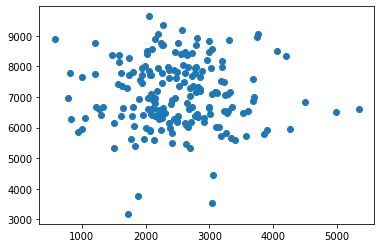

probing variety rice_irri
*** season Y06_07 ***


100%|██████████| 365/365 [00:05<00:00, 62.23it/s]


*** season Y07_08 ***


100%|██████████| 365/365 [00:06<00:00, 54.66it/s]


*** season Y08_09 ***


100%|██████████| 365/365 [00:06<00:00, 56.60it/s]


*** season Y09_10 ***


100%|██████████| 365/365 [00:06<00:00, 58.08it/s]


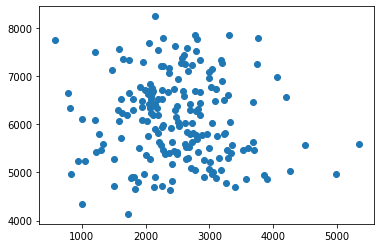

probing variety rice_501
probing variety rice_HYV_IR8
probing variety Rice_IR64616H_DS
*** season Y06_07 ***


100%|██████████| 365/365 [00:05<00:00, 70.04it/s]


*** season Y07_08 ***


100%|██████████| 365/365 [00:06<00:00, 57.10it/s]


*** season Y08_09 ***


100%|██████████| 365/365 [00:07<00:00, 48.98it/s]


*** season Y09_10 ***


100%|██████████| 365/365 [00:06<00:00, 54.79it/s]


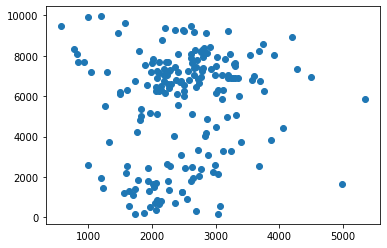

probing variety Rice_IR64616H_WS
*** season Y06_07 ***


100%|██████████| 365/365 [00:05<00:00, 66.33it/s]


*** season Y07_08 ***


100%|██████████| 365/365 [00:06<00:00, 60.07it/s]


*** season Y08_09 ***


100%|██████████| 365/365 [00:06<00:00, 54.05it/s]


*** season Y09_10 ***


100%|██████████| 365/365 [00:07<00:00, 50.55it/s]


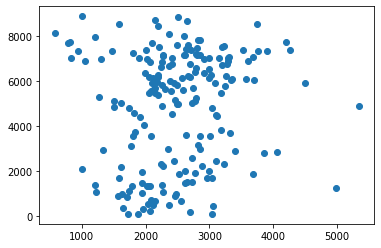

probing variety Rice_IR64
*** season Y06_07 ***


 62%|██████▏   | 227/365 [00:03<00:02, 55.37it/s]

In [20]:
# optimizer.probe
    # WOFOST TSUM1, TSUM2

WOFOST_params = {    
    "rice_eu" : (875, 625),
    "rice_irri" : (800, 465),
    "rice_501" : (875, 625),
    "rice_HYV_IR8" : (800, 465),
    "Rice_IR64616H_DS" : (1420, 680),
    "Rice_IR64616H_WS" : (1500, 580),
    "Rice_IR64" : (1570, 770),
    "rice_IR72" : (1420, 630),
    "Rice_IR72_DS" : (1420, 630),
    "Rice_IR72_WS" : (1550, 600),
    "Rice_IR8A" : (1633, 506),
}

for variety in WOFOST_params:
    print("probing variety",variety)

    optimizer.probe(
        params={
            'SDJBVP': WOFOST_params[variety][0]/2,
            'SDJRPR': WOFOST_params[variety][0]/2,
            'SDJMatu1': WOFOST_params[variety][1]/2,
            'SDJMatu2': WOFOST_params[variety][1]/2,
        },
        lazy=False,
    )

In [ ]:
optimizer.maximize(init_points=10, n_iter=10)

In [ ]:
xx

In [ ]:
# https://github.com/fmfn/BayesianOptimization/blob/master/examples/exploitation_vs_exploration.ipynb
optimizer.maximize(n_iter=10, acq="ucb", kappa=10) # 
optimizer.maximize(n_iter=10, acq="ei", xi=1e-4)

In [ ]:
optimizer.max

{'target': 0.03955217654494106,
 'params': {'SDJBVP': 200.0,
  'SDJMatu1': 330.56294200127616,
  'SDJMatu2': 375.0,
  'SDJRPR': 200.0}}